In [2]:
import basicGridModel
import numpy as np
import tensorflow as tf
from tensorflow import keras

In [3]:
from __future__ import absolute_import, division, print_function

import base64
import imageio
import IPython
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
import pyvirtualdisplay

import tensorflow as tf

from tf_agents.agents.dqn import dqn_agent
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import sequential
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.specs import tensor_spec
from tf_agents.utils import common

In [4]:
num_iterations = 20000 # @param {type:"integer"}

initial_collect_steps = 100  # @param {type:"integer"} 
collect_steps_per_iteration = 1  # @param {type:"integer"}
replay_buffer_max_length = 100000  # @param {type:"integer"}

batch_size = 64  # @param {type:"integer"}
learning_rate = 1e-3  # @param {type:"number"}
log_interval = 200  # @param {type:"integer"}

num_eval_episodes = 10  # @param {type:"integer"}
eval_interval = 1000  # @param {type:"integer"}

In [5]:
env = basicGridModel.discretePath3(20,20) # Grid Size
obs = env.reset()
obs

array([12, 10, 10,  5])

In [7]:
env.cmd_plot()

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 4. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 3. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

In [8]:
print('Observation Spec:')
print(env.time_step_spec().observation)

Observation Spec:


AttributeError: 'discretePath3' object has no attribute 'time_step_spec'

In [41]:
print('Reward Spec:')
print(env.time_step_spec().reward)

Reward Spec:
ArraySpec(shape=(), dtype=dtype('float32'), name='reward')


In [42]:
print('Action Spec:')
print(env.action_spec())

Action Spec:
BoundedArraySpec(shape=(), dtype=dtype('int64'), name='action', minimum=0, maximum=1)


In [43]:
time_step = env.reset()
print('Time step:')
print(time_step)

action = np.array(1, dtype=np.int32)

next_time_step = env.step(action)
print('Next time step:')
print(next_time_step)

Time step:
TimeStep(
{'discount': array(1., dtype=float32),
 'observation': array([-0.01982621, -0.03738579, -0.04698693,  0.04392102], dtype=float32),
 'reward': array(0., dtype=float32),
 'step_type': array(0)})
Next time step:
TimeStep(
{'discount': array(1., dtype=float32),
 'observation': array([-0.02057393,  0.15837733, -0.04610851, -0.26320866], dtype=float32),
 'reward': array(1., dtype=float32),
 'step_type': array(1)})


In [44]:
train_py_env = suite_gym.load(env_name) #For Training
eval_py_env = suite_gym.load(env_name) # For Evaluation

In [45]:
train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

In [46]:
fc_layer_params = (100, 50)
action_tensor_spec = tensor_spec.from_spec(env.action_spec())
num_actions = action_tensor_spec.maximum - action_tensor_spec.minimum + 1

# Define a helper function to create Dense layers configured with the right
# activation and kernel initializer.
def dense_layer(num_units):
  return tf.keras.layers.Dense(
      num_units,
      activation=tf.keras.activations.relu,
      kernel_initializer=tf.keras.initializers.VarianceScaling(
          scale=2.0, mode='fan_in', distribution='truncated_normal'))

# QNetwork consists of a sequence of Dense layers followed by a dense layer
# with `num_actions` units to generate one q_value per available action as
# it's output.
dense_layers = [dense_layer(num_units) for num_units in fc_layer_params]
q_values_layer = tf.keras.layers.Dense(
    num_actions,
    activation=None,
    kernel_initializer=tf.keras.initializers.RandomUniform(
        minval=-0.03, maxval=0.03),
    bias_initializer=tf.keras.initializers.Constant(-0.2))
q_net = sequential.Sequential(dense_layers + [q_values_layer])

In [47]:
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

train_step_counter = tf.Variable(0)

agent = dqn_agent.DqnAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    td_errors_loss_fn=common.element_wise_squared_loss,
    train_step_counter=train_step_counter)

agent.initialize()

In [48]:
eval_policy = agent.policy
collect_policy = agent.collect_policy

In [49]:
random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(),
                                                train_env.action_spec())

In [50]:
example_environment = tf_py_environment.TFPyEnvironment(
    suite_gym.load('CartPole-v0'))

In [51]:
time_step = example_environment.reset()

In [52]:
random_policy.action(time_step)

PolicyStep(action=<tf.Tensor: shape=(1,), dtype=int64, numpy=array([0], dtype=int64)>, state=(), info=())

In [53]:
def compute_avg_return(environment, policy, num_episodes=10):

  total_return = 0.0
  for _ in range(num_episodes):

    time_step = environment.reset()
    episode_return = 0.0

    while not time_step.is_last():
      action_step = policy.action(time_step)
      time_step = environment.step(action_step.action)
      episode_return += time_step.reward
    total_return += episode_return

  avg_return = total_return / num_episodes
  return avg_return.numpy()[0]


# See also the metrics module for standard implementations of different metrics.
# https://github.com/tensorflow/agents/tree/master/tf_agents/metrics

In [54]:
compute_avg_return(eval_env, random_policy, num_eval_episodes)

23.3

In [55]:
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=replay_buffer_max_length)

In [56]:
agent.collect_data_spec


Trajectory(
{'action': BoundedTensorSpec(shape=(), dtype=tf.int64, name='action', minimum=array(0, dtype=int64), maximum=array(1, dtype=int64)),
 'discount': BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32)),
 'next_step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type'),
 'observation': BoundedTensorSpec(shape=(4,), dtype=tf.float32, name='observation', minimum=array([-4.8000002e+00, -3.4028235e+38, -4.1887903e-01, -3.4028235e+38],
      dtype=float32), maximum=array([4.8000002e+00, 3.4028235e+38, 4.1887903e-01, 3.4028235e+38],
      dtype=float32)),
 'policy_info': (),
 'reward': TensorSpec(shape=(), dtype=tf.float32, name='reward'),
 'step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type')})

In [57]:
agent.collect_data_spec._fields


('step_type',
 'observation',
 'action',
 'policy_info',
 'next_step_type',
 'reward',
 'discount')

In [58]:
def collect_step(environment, policy, buffer):
  time_step = environment.current_time_step()
  action_step = policy.action(time_step)
  next_time_step = environment.step(action_step.action)
  traj = trajectory.from_transition(time_step, action_step, next_time_step)

  # Add trajectory to the replay buffer
  buffer.add_batch(traj)

def collect_data(env, policy, buffer, steps):
  for _ in range(steps):
    collect_step(env, policy, buffer)

collect_data(train_env, random_policy, replay_buffer, initial_collect_steps)

# This loop is so common in RL, that we provide standard implementations. 
# For more details see tutorial 4 or the drivers module.
# https://github.com/tensorflow/agents/blob/master/docs/tutorials/4_drivers_tutorial.ipynb 
# https://www.tensorflow.org/agents/api_docs/python/tf_agents/drivers

In [59]:
# Uncomment to peel one of these off and inspect it.
# iter(replay_buffer.as_dataset()).next()

In [60]:
# Dataset generates trajectories with shape [Bx2x...]
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3, 
    sample_batch_size=batch_size, 
    num_steps=2).prefetch(3)


dataset

<PrefetchDataset shapes: (Trajectory(
{action: (64, 2),
 discount: (64, 2),
 next_step_type: (64, 2),
 observation: (64, 2, 4),
 policy_info: (),
 reward: (64, 2),
 step_type: (64, 2)}), BufferInfo(ids=(64, 2), probabilities=(64,))), types: (Trajectory(
{action: tf.int64,
 discount: tf.float32,
 next_step_type: tf.int32,
 observation: tf.float32,
 policy_info: (),
 reward: tf.float32,
 step_type: tf.int32}), BufferInfo(ids=tf.int64, probabilities=tf.float32))>

In [61]:
iterator = iter(dataset)
print(iterator)

In [62]:
# Uncomment to see what the dataset iterator is feeding to the agent.
# Compare this representation of replay data 
# to the collection of individual trajectories shown earlier.

# iterator.next()

In [63]:
try:
  %%time
except:
  pass

# (Optional) Optimize by wrapping some of the code in a graph using TF function.
agent.train = common.function(agent.train)

# Reset the train step
agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
returns = [avg_return]

for _ in range(num_iterations):

  # Collect a few steps using collect_policy and save to the replay buffer.
  collect_data(train_env, agent.collect_policy, replay_buffer, collect_steps_per_iteration)

  # Sample a batch of data from the buffer and update the agent's network.
  experience, unused_info = next(iterator)
  train_loss = agent.train(experience).loss

  step = agent.train_step_counter.numpy()

  if step % log_interval == 0:
    print('step = {0}: loss = {1}'.format(step, train_loss))

  if step % eval_interval == 0:
    avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
    print('step = {0}: Average Return = {1}'.format(step, avg_return))
    returns.append(avg_return)

Exception ignored in: <function Viewer.__del__ at 0x00000220D441F820>
Traceback (most recent call last):
  File "C:\Users\poojai1\Anaconda3\lib\site-packages\gym\envs\classic_control\rendering.py", line 165, in __del__
    self.close()
  File "C:\Users\poojai1\Anaconda3\lib\site-packages\gym\envs\classic_control\rendering.py", line 83, in close
    self.window.close()
  File "C:\Users\poojai1\Anaconda3\lib\site-packages\pyglet\window\win32\__init__.py", line 319, in close
    super(Win32Window, self).close()
  File "C:\Users\poojai1\Anaconda3\lib\site-packages\pyglet\window\__init__.py", line 838, in close
    app.windows.remove(self)
  File "C:\Users\poojai1\Anaconda3\lib\_weakrefset.py", line 109, in remove
    self.data.remove(ref(item))
KeyError: <weakref at 0x00000220D43CD4F0; to 'Win32Window' at 0x00000220D3F9EF40>


step = 200: loss = 15.136507034301758
step = 400: loss = 4.012071132659912
step = 600: loss = 35.83407974243164
step = 800: loss = 104.96697235107422
step = 1000: loss = 9.516736030578613
step = 1000: Average Return = 62.70000076293945
step = 1200: loss = 13.363763809204102
step = 1400: loss = 14.825506210327148
step = 1600: loss = 16.830751419067383
step = 1800: loss = 93.49717712402344
step = 2000: loss = 412.6571044921875
step = 2000: Average Return = 200.0
step = 2200: loss = 31.95194435119629
step = 2400: loss = 141.32681274414062
step = 2600: loss = 259.7391357421875
step = 2800: loss = 979.8907470703125
step = 3000: loss = 456.42340087890625
step = 3000: Average Return = 200.0
step = 3200: loss = 494.4441833496094
step = 3400: loss = 552.9183349609375
step = 3600: loss = 74113.4296875
step = 3800: loss = 4335.1591796875
step = 4000: loss = 7209.3603515625
step = 4000: Average Return = 200.0
step = 4200: loss = 8659.001953125
step = 4400: loss = 41241.6875
step = 4600: loss = 659

In [64]:
compute_avg_return(eval_env, agent.policy, num_eval_episodes)

200.0

(-0.44499959945678746, 250.0)

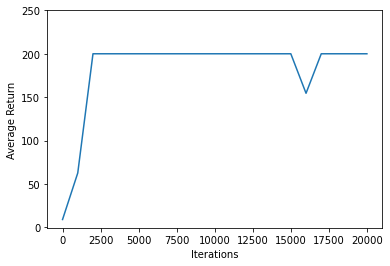

In [65]:
iterations = range(0, num_iterations + 1, eval_interval)
plt.plot(iterations, returns)
plt.ylabel('Average Return')
plt.xlabel('Iterations')
plt.ylim(top=250)

In [66]:
#Embeds videos into the notebook for visualization
def embed_mp4(filename):
  """Embeds an mp4 file in the notebook."""
  video = open(filename,'rb').read()
  b64 = base64.b64encode(video)
  tag = '''
  <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
  Your browser does not support the video tag.
  </video>'''.format(b64.decode())

  return IPython.display.HTML(tag)

In [67]:
def create_policy_eval_video(policy, filename, num_episodes=5, fps=30):
  filename = filename + ".mp4"
  with imageio.get_writer(filename, fps=fps) as video:
    for _ in range(num_episodes):
      time_step = eval_env.reset()
      video.append_data(eval_py_env.render())
      while not time_step.is_last():
        action_step = policy.action(time_step)
        time_step = eval_env.step(action_step.action)
        video.append_data(eval_py_env.render())
  return embed_mp4(filename)




create_policy_eval_video(agent.policy, "trained-agent")

ImportError: To use the imageio ffmpeg plugin you need to 'pip install imageio-ffmpeg'

In [ ]:
#Trained agent
create_policy_eval_video(agent.policy, "trained-agent")

In [ ]:
#random agent
create_policy_eval_video(random_policy, "random-agent")